In [ ]:
!pip install datasets transformers rouge-score nltk rouge_chinese

In [1]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
ds = Dataset.load_from_disk("./nlpcc_2017/")
ds = ds.train_test_split(200, seed=42)
ds

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-24 15:10:25.665680: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 15:10:25.704528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:10:26.660540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loadin

DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 4800
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 200
    })
})

In [2]:
from modelscope import snapshot_download
model_dir = snapshot_download("langboat/mengzi-t5-base")

2024-07-24 15:10:30,814 - modelscope - INFO - PyTorch version 2.0.1+cu118 Found.
2024-07-24 15:10:30,816 - modelscope - INFO - TensorFlow version 2.13.0 Found.
2024-07-24 15:10:30,817 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2024-07-24 15:10:30,844 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 e096d041fdba41d8d7d7331b3f469288 and a total number of 945 components indexed
2024-07-24 15:10:31,518 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
def process_func(exmaples):
    contents = ["摘要生成: \n" + e for e in exmaples["content"]]
    inputs = tokenizer(contents, max_length=512, truncation=True)
    labels = tokenizer(text_target=exmaples["title"], max_length=64, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_ds = ds.map(process_func, batched=True)
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4800
    })
    test: Dataset({
        features: ['title', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

In [6]:
import numpy as np
from rouge_chinese import Rouge
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

rouge = Rouge()

def compute_metric(evalPred):
    def calculate_bleu_scores(candidate, references):
        candidate = list(candidate.split(" "))
        reference = [list(references.split(" "))]
        weights_list = [
            (1, 0, 0, 0),   # BLEU-1
            (0.5, 0.5, 0, 0),   # BLEU-2
            (1/3, 1/3, 1/3, 0),   # BLEU-3
            (0.25, 0.25, 0.25, 0.25) # BLEU-4
        ]

        bleu_scores = []
        for weights in weights_list:
            # print(sentence_bleu(reference, candidate, weights=weights))
            score = sentence_bleu(reference, candidate, weights=weights)
            bleu_scores.append(score)
        return bleu_scores
    predictions, labels = evalPred
    decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decode_preds = [" ".join(p) for p in decode_preds]
    decode_labels = [" ".join(l) for l in decode_labels]
    rouge_scores = rouge.get_scores(decode_preds, decode_labels, avg=True)
    bleu_scores_batch = np.mean(np.array([calculate_bleu_scores(cand, refs) for cand, refs in zip(decode_preds, decode_labels)]), axis=0)
    return {
        "rouge-1": rouge_scores["rouge-1"]["f"],
        "rouge-2": rouge_scores["rouge-2"]["f"],
        "rouge-l": rouge_scores["rouge-l"]["f"],
        "bleu-l": bleu_scores_batch[0],
        "bleu-2": bleu_scores_batch[1],
        "bleu-3": bleu_scores_batch[2],
        "bleu-4": bleu_scores_batch[3],
    }

In [8]:
import matplotlib.pyplot as plt
from transformers import Seq2SeqTrainingArguments, TrainerCallback
from transformers.trainer_utils import TrainOutput

args = Seq2SeqTrainingArguments(
    output_dir="./summary_mengzi2",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=10,
    logging_steps=60,
    evaluation_strategy='steps',
    save_strategy="epoch",
    metric_for_best_model="rouge-l",
    predict_with_generate=True,
    fp16=True,
    save_total_limit=2,
    num_train_epochs = 5,
)
trainer = Seq2SeqTrainer(
    args=args,
    model=model,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metric,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer)
)

In [9]:
torch.cuda.empty_cache()
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l,Bleu-l,Bleu-2,Bleu-3,Bleu-4
60,3.400000,2.379797,0.459748,0.288363,0.377964,0.293812,0.233710,0.184882,0.148324
120,2.588600,2.192331,0.459283,0.289870,0.381893,0.296858,0.236400,0.187097,0.151334
180,2.208700,2.092213,0.480827,0.310988,0.398959,0.308126,0.249762,0.201054,0.163218
240,2.171900,2.030565,0.483134,0.313959,0.400135,0.308054,0.251772,0.202723,0.167078
300,1.914500,1.988252,0.486084,0.319824,0.408575,0.309623,0.252847,0.205110,0.169385
360,1.880200,1.955122,0.503803,0.336483,0.424860,0.324288,0.267143,0.216237,0.180049
420,1.700600,1.951979,0.490873,0.325677,0.409890,0.315357,0.258841,0.210337,0.171878
480,1.725300,1.925564,0.489011,0.325743,0.407710,0.315682,0.260524,0.211829,0.175121
540,1.596100,1.927225,0.494811,0.329857,0.417450,0.317139,0.261861,0.213126,0.177268
600,1.624700,1.919257,0.497598,0.333083,0.417189,0.320371,0.264774,0.215907,0.179795


/opt/conda/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/transla

TrainOutput(global_step=600, training_loss=2.0810597356160483, metrics={'train_runtime': 744.0225, 'train_samples_per_second': 32.257, 'train_steps_per_second': 0.806, 'total_flos': 9761296304148480.0, 'train_loss': 2.0810597356160483, 'epoch': 5.0})

In [10]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_file_path = 'summary_mengzi2/runs/Jul24_15-12-02_dsw-584084-54b5bd5897-ddk5q/events.out.tfevents.1721805136.dsw-584084-54b5bd5897-ddk5q.1748.0'

ea = EventAccumulator(event_file_path)
ea.Reload()
train_loss_metric_data = {}
rel_name_need = ['train/loss', 'eval/loss', 'eval/rouge-1', 'eval/rouge-2', 'eval/rouge-l', 'eval/bleu-l', 'eval/bleu-2', 'eval/bleu-3', 'eval/bleu-4']
for tag in ea.Tags()['scalars']:
    # print(tag, '\n')
    if tag not in rel_name_need:
        continue
    train_loss_metric_data[tag] = []
    for scalar_event in ea.Scalars(tag):
        # print(scalar_event.wall_time)
        train_loss_metric_data[tag].append(scalar_event.value)
print(train_loss_metric_data.keys())

dict_keys(['train/loss', 'eval/loss', 'eval/rouge-1', 'eval/rouge-2', 'eval/rouge-l', 'eval/bleu-l', 'eval/bleu-2', 'eval/bleu-3', 'eval/bleu-4'])


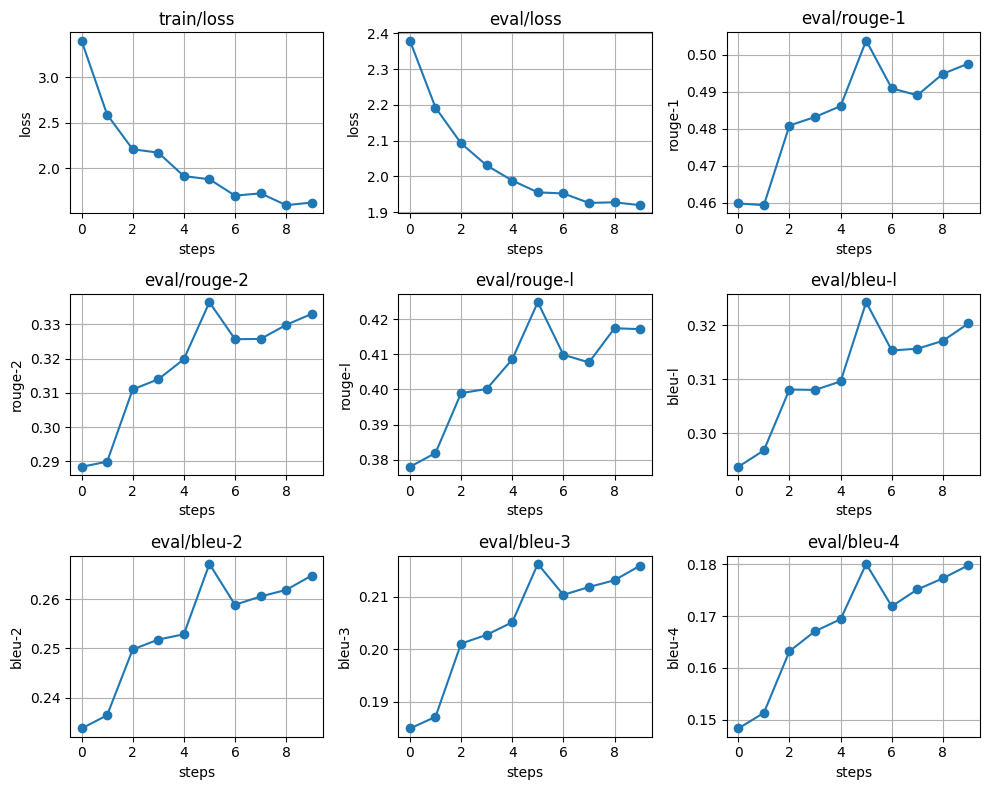

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个新的figure对象，设置其大小
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
# if not isinstance(axs, np.ndarray):
#     axs = [axs]
# 遍历数据字典中的每个键值对
for i, (key, values) in enumerate(train_loss_metric_data.items()):
    row = i // 3  # 计算行索引
    col = i % 3   # 计算列索引
    # 在相应的子图上绘制数据
    # print(values)
    axs[row, col].plot(range(len(values)), values, 'o-')
    axs[row, col].set_title(key)  # 设置子图标题
    axs[row, col].set_xlabel('steps')  # 设置x轴标签
    axs[row, col].set_ylabel(key.split('/')[1])  # 设置y轴标签
    axs[row, col].grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [2]:
from transformers import pipeline
model_dir = './summary_learn/checkpoint-360'
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

In [3]:
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

In [4]:
pipe("摘要生成:\n" + ds["test"][-1]["content"], max_length=64, do_sample=True)

[{'generated_text': '美国男子同意妻子前往火星单程出行的单程旅行,为开拓人类的居住地。'}]

In [5]:
ds["test"][-1]["title"]

'美男子称将把妻子送往火星:预计2026年启程,目标是开拓人类居住地;男子称虽想念妻子但任务意义更大。'